In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import datetime
import matplotlib.pyplot as plt
import contextily as cx
import seaborn as sns

## 读数据

In [3]:
path = 'process data/'
df = pd.read_csv(path + 'dataset_4_raw.csv')
df

,device_id,latitude,longitude,device_home_latitude,device_home_longitude,date
0,f654d4a6-3850-4021-98df-1e4de5d5a945,22.291246,114.198296,22.378021,114.258036,2023-09-01 08:41:01
1,f654d4a6-3850-4021-98df-1e4de5d5a945,22.269249,114.240915,22.378021,114.258036,2023-09-01 15:24:05
2,f6580b80-1451-48b9-b99f-685c17a54fc8,22.339961,114.134779,22.365877,114.136828,2023-09-03 19:00:55
3,f6580b80-1451-48b9-b99f-685c17a54fc8,22.339928,114.134885,22.365877,114.136828,2023-09-03 19:07:21
4,f6580b80-1451-48b9-b99f-685c17a54fc8,22.339945,114.134766,22.365877,114.136828,2023-09-03 19:13:10
...,...,...,...,...,...,...
59839133,b459657d-9ab1-4f73-9154-28f6044e2df7,22.321531,114.260227,22.321534,114.260255,2023-09-11 20:48:15
59839134,b459657d-9ab1-4f73-9154-28f6044e2df7,22.321526,114.260260,22.321534,114.260255,2023-09-11 20:53:18
59839135,b459657d-9ab1-4f73-9154-28f6044e2df7,22.321577,114.260256,22.321534,114.260255,2023-09-11 21:44:53
59839136,b4797889-7ba8-6302-2099-7fd7d0cf6e40,22.281597,114.159020,22.266985,114.234298,2023-09-03 12:55:23


In [4]:
import datetime
df['date'] = pd.to_datetime(df['date'])

In [5]:
df_15 = df[(df['date'].dt.hour >= 1) & (df['date'].dt.hour <= 5)] # 凌晨1：00至3：59的数据
df_15 = df_15[['device_id','latitude','longitude','device_home_latitude','device_home_longitude']]
df_15

,device_id,latitude,longitude,device_home_latitude,device_home_longitude
30,f46a65f1-db93-477b-a2e6-798f09b778a3,22.326504,114.257659,22.327950,114.258985
31,f46a65f1-db93-477b-a2e6-798f09b778a3,22.326499,114.257590,22.327950,114.258985
32,f46a65f1-db93-477b-a2e6-798f09b778a3,22.326479,114.257576,22.327950,114.258985
40,f4a37500-1401-4766-9be9-0b7492d7066f,22.315801,114.217589,22.316722,114.217165
129,f6ec9f4b-8020-467c-be2c-df948aebe5dc,22.441668,114.072768,22.441666,114.072836
...,...,...,...,...,...
59839073,b56a2980-91b2-415d-945f-8a445d5bbe60,22.316358,114.174779,22.316361,114.174784
59839074,b56a2980-91b2-415d-945f-8a445d5bbe60,22.316356,114.174787,22.316361,114.174784
59839075,b56a2980-91b2-415d-945f-8a445d5bbe60,22.316356,114.174780,22.316361,114.174784
59839076,b56a2980-91b2-415d-945f-8a445d5bbe60,22.316359,114.174702,22.316361,114.174784


## 读取香港building shape file

In [6]:
shapefile = gpd.read_file('Building_SHP/BUILDING_STRUCTURE.shp', encoding="GBK")
shapefile = shapefile.to_crs('EPSG:4326')
building_shp = shapefile[shapefile['BUILDING00'] == 'T']
building_shp = building_shp[['BUILDINGST', 'geometry']]
building_shp

,BUILDINGST,geometry
0,243561,"POLYGON ((113.84091 22.21870, 113.84090 22.218..."
1,243562,"POLYGON ((113.84094 22.21863, 113.84095 22.218..."
2,243563,"POLYGON ((113.84090 22.21867, 113.84091 22.218..."
3,243564,"POLYGON ((113.84097 22.21871, 113.84101 22.218..."
4,243565,"POLYGON ((113.84102 22.21870, 113.84101 22.218..."
...,...,...
340747,403798,"POLYGON ((114.43641 22.53999, 114.43638 22.539..."
340748,4963,"POLYGON ((114.43640 22.54116, 114.43640 22.541..."
340749,4952,"POLYGON ((114.43668 22.54119, 114.43659 22.541..."
340750,5040,"POLYGON ((114.43675 22.54050, 114.43670 22.540..."


In [7]:
## 定义一个 building_lat_lon_df ，存储 建筑物的 id 和 中心点经纬度
building_lat_lon_df = pd.DataFrame(columns=['BUILDINGST', 'latitude', 'longitude'])

building_lat_lon_list = []

## 获取每个建筑物的中心点经纬度
for idx, row in building_shp.iterrows():
    if idx == 85188:
        print('已读取25%')
    elif idx == 170376:
        print('已读取50%')
    elif idx == 255564:
        print('已读取50%')
    elif idx == 340751:
        print('已读取100%')
    geometry = row['geometry']
    centroid = geometry.centroid
    lon = centroid.x
    lat = centroid.y
    
    # 存到字典
    building_lat_lon_data = {'BUILDINGST': idx, 'latitude': lat, 'longitude': lon}
    
    # 将字典添加到列表
    building_lat_lon_list.append(building_lat_lon_data)

# 使用pd.concat()方法将列表转换为DataFrame
building_lat_lon_df = pd.concat([building_lat_lon_df, pd.DataFrame(building_lat_lon_list)])

building_lat_lon_df

已读取25%
已读取50%
已读取50%
已读取100%


,BUILDINGST,latitude,longitude
0,0,22.218678,113.840891
1,1,22.218621,113.840924
2,2,22.218693,113.840934
3,3,22.218686,113.840983
4,4,22.218720,113.841003
...,...,...,...
332013,340747,22.539980,114.436365
332014,340748,22.541139,114.436364
332015,340749,22.541258,114.436660
332016,340750,22.540524,114.436728


In [8]:
building_lat_lon_df.dtypes

BUILDINGST     object
latitude      float64
longitude     float64
dtype: object

## 住址经纬度df

In [9]:
home_lat_lon_df = df[['device_id','device_home_latitude','device_home_longitude']]
home_lat_lon_df = home_lat_lon_df.drop_duplicates()
home_lat_lon_df

,device_id,device_home_latitude,device_home_longitude
0,f654d4a6-3850-4021-98df-1e4de5d5a945,22.378021,114.258036
2,f6580b80-1451-48b9-b99f-685c17a54fc8,22.365877,114.136828
10,f68a046d-48d6-41bc-a8dc-8210b026d2a7,22.407392,114.224594
14,f6a013e3-3b28-6d4d-bf34-ab0f00d3493a,22.324517,114.160602
15,e9872505-727b-42f7-b4d5-efe02dc948d7,22.336465,114.245417
...,...,...,...
54706209,a88227b1-8718-49a2-a5d0-5e1e5dcfa68e,22.367530,114.127846
55123313,8db9bafa-5222-4f46-b5b2-49a3d6519dfc,22.469127,114.006127
55997466,a4158a52-3c61-4f02-abbb-f035faa6faee,22.257824,114.165734
56447442,eebeebff-812f-4be2-aaa4-94f86c528427,22.290000,114.150000


In [10]:
## 转换为 GeoDataFrame
geometry = gpd.points_from_xy(home_lat_lon_df['device_home_longitude'], home_lat_lon_df['device_home_latitude'])
home_lat_lon_gdf = gpd.GeoDataFrame(home_lat_lon_df, geometry=geometry)
home_lat_lon_gdf.crs = 'EPSG:4326'
home_lat_lon_gdf = home_lat_lon_gdf.drop(['device_home_longitude','device_home_latitude'], axis=1)
home_lat_lon_gdf

,device_id,geometry
0,f654d4a6-3850-4021-98df-1e4de5d5a945,POINT (114.25804 22.37802)
2,f6580b80-1451-48b9-b99f-685c17a54fc8,POINT (114.13683 22.36588)
10,f68a046d-48d6-41bc-a8dc-8210b026d2a7,POINT (114.22459 22.40739)
14,f6a013e3-3b28-6d4d-bf34-ab0f00d3493a,POINT (114.16060 22.32452)
15,e9872505-727b-42f7-b4d5-efe02dc948d7,POINT (114.24542 22.33646)
...,...,...
54706209,a88227b1-8718-49a2-a5d0-5e1e5dcfa68e,POINT (114.12785 22.36753)
55123313,8db9bafa-5222-4f46-b5b2-49a3d6519dfc,POINT (114.00613 22.46913)
55997466,a4158a52-3c61-4f02-abbb-f035faa6faee,POINT (114.16573 22.25782)
56447442,eebeebff-812f-4be2-aaa4-94f86c528427,POINT (114.15000 22.29000)


In [11]:
## 映射到building
home_merged_gdf = gpd.sjoin(building_shp, home_lat_lon_gdf, how='inner', predicate='intersects')
# home_merged_gdf = home_merged_gdf.drop('index_right', axis=1)
home_merged_gdf

,BUILDINGST,geometry,index_right,device_id
310,246850,"POLYGON ((113.85992 22.25518, 113.85987 22.255...",11403822,9d84fd00-873a-4473-9c17-42bbf0402455
483,186396,"POLYGON ((113.86199 22.25448, 113.86187 22.254...",1922445,7da1b9a7-3908-475e-a766-638b5d760eb7
573,246925,"POLYGON ((113.86239 22.25465, 113.86238 22.254...",31462,4b625d9c-fc79-465f-8315-8f39cca15e0e
698,174391,"POLYGON ((113.86287 22.24768, 113.86284 22.247...",1748385,8f47afdb-70aa-438b-a65b-c23e70f1a7be
805,196917,"POLYGON ((113.86318 22.25502, 113.86318 22.255...",798841,eb9023f1-b06a-4e4f-8a53-cae203f32b24
...,...,...,...,...
338948,60539,"POLYGON ((114.31958 22.44845, 114.31961 22.448...",244952,0efd6c0d-6f95-47b9-a4b6-f0724a970a8f
339357,343166,"POLYGON ((114.32680 22.43128, 114.32686 22.431...",5079117,908023fa-e3a1-4a58-8b4c-c8b358ce252a
339447,45990,"POLYGON ((114.32859 22.45994, 114.32859 22.460...",4066645,9c63161a-3895-4dc9-820d-2de8fbeae333
339848,138660,"POLYGON ((114.35282 22.34764, 114.35281 22.347...",4499660,b2a074a2-fd10-463b-adc3-14288ae32f9c


In [12]:
home_building_df = home_merged_gdf[['device_id','BUILDINGST']]
home_building_df

,device_id,BUILDINGST
310,9d84fd00-873a-4473-9c17-42bbf0402455,246850
483,7da1b9a7-3908-475e-a766-638b5d760eb7,186396
573,4b625d9c-fc79-465f-8315-8f39cca15e0e,246925
698,8f47afdb-70aa-438b-a65b-c23e70f1a7be,174391
805,eb9023f1-b06a-4e4f-8a53-cae203f32b24,196917
...,...,...
338948,0efd6c0d-6f95-47b9-a4b6-f0724a970a8f,60539
339357,908023fa-e3a1-4a58-8b4c-c8b358ce252a,343166
339447,9c63161a-3895-4dc9-820d-2de8fbeae333,45990
339848,b2a074a2-fd10-463b-adc3-14288ae32f9c,138660


## 位置经纬度df

In [13]:
location_lat_lon_df = df[['device_id','latitude','longitude']]
location_lat_lon_df

,device_id,latitude,longitude
0,f654d4a6-3850-4021-98df-1e4de5d5a945,22.291246,114.198296
1,f654d4a6-3850-4021-98df-1e4de5d5a945,22.269249,114.240915
2,f6580b80-1451-48b9-b99f-685c17a54fc8,22.339961,114.134779
3,f6580b80-1451-48b9-b99f-685c17a54fc8,22.339928,114.134885
4,f6580b80-1451-48b9-b99f-685c17a54fc8,22.339945,114.134766
...,...,...,...
59839133,b459657d-9ab1-4f73-9154-28f6044e2df7,22.321531,114.260227
59839134,b459657d-9ab1-4f73-9154-28f6044e2df7,22.321526,114.260260
59839135,b459657d-9ab1-4f73-9154-28f6044e2df7,22.321577,114.260256
59839136,b4797889-7ba8-6302-2099-7fd7d0cf6e40,22.281597,114.159020


In [14]:
## 转换为 GeoDataFrame
geometry = gpd.points_from_xy(location_lat_lon_df['longitude'], location_lat_lon_df['latitude'])
location_lat_lon_gdf = gpd.GeoDataFrame(location_lat_lon_df, geometry=geometry)
location_lat_lon_gdf.crs = 'EPSG:4326'
location_lat_lon_gdf = location_lat_lon_gdf.drop(['longitude','latitude'], axis=1)
location_lat_lon_gdf

,device_id,geometry
0,f654d4a6-3850-4021-98df-1e4de5d5a945,POINT (114.19830 22.29125)
1,f654d4a6-3850-4021-98df-1e4de5d5a945,POINT (114.24092 22.26925)
2,f6580b80-1451-48b9-b99f-685c17a54fc8,POINT (114.13478 22.33996)
3,f6580b80-1451-48b9-b99f-685c17a54fc8,POINT (114.13489 22.33993)
4,f6580b80-1451-48b9-b99f-685c17a54fc8,POINT (114.13477 22.33994)
...,...,...
59839133,b459657d-9ab1-4f73-9154-28f6044e2df7,POINT (114.26023 22.32153)
59839134,b459657d-9ab1-4f73-9154-28f6044e2df7,POINT (114.26026 22.32153)
59839135,b459657d-9ab1-4f73-9154-28f6044e2df7,POINT (114.26026 22.32158)
59839136,b4797889-7ba8-6302-2099-7fd7d0cf6e40,POINT (114.15902 22.28160)


In [15]:
## 映射到building
location_merged_gdf = gpd.sjoin(building_shp, location_lat_lon_gdf, how='inner', predicate='intersects')
# location_merged_gdf = location_merged_gdf.drop('index_right', axis=1)
location_merged_gdf

,BUILDINGST,geometry,index_right,device_id
12,171065,"POLYGON ((113.84601 22.19589, 113.84602 22.195...",881723,c8d7f49b-7db3-414d-bcc4-91f4243bafcc
14,366882,"POLYGON ((113.84830 22.22462, 113.84830 22.224...",50258521,dae59cd1-9e67-42ca-ac92-79c069af4f89
14,366882,"POLYGON ((113.84830 22.22462, 113.84830 22.224...",40560582,dae59cd1-9e67-42ca-ac92-79c069af4f89
14,366882,"POLYGON ((113.84830 22.22462, 113.84830 22.224...",58973364,dae59cd1-9e67-42ca-ac92-79c069af4f89
14,366882,"POLYGON ((113.84830 22.22462, 113.84830 22.224...",55710116,dae59cd1-9e67-42ca-ac92-79c069af4f89
...,...,...,...,...
340620,423138,"POLYGON ((114.37589 22.41122, 114.37586 22.411...",20389531,391d4fc3-5256-4adc-80d0-3513d0128c15
340638,111187,"POLYGON ((114.37648 22.41132, 114.37635 22.411...",15850286,4ff53e4d-1593-44f3-9d17-1ec1d1bc6d45
340639,236412,"POLYGON ((114.37635 22.41129, 114.37648 22.411...",3120162,043afb65-77c1-41cf-821c-3942595f0d0e
340639,236412,"POLYGON ((114.37635 22.41129, 114.37648 22.411...",15850283,4ff53e4d-1593-44f3-9d17-1ec1d1bc6d45


In [16]:
location_building_df = location_merged_gdf[['device_id','BUILDINGST']]
location_building_df

,device_id,BUILDINGST
12,c8d7f49b-7db3-414d-bcc4-91f4243bafcc,171065
14,dae59cd1-9e67-42ca-ac92-79c069af4f89,366882
14,dae59cd1-9e67-42ca-ac92-79c069af4f89,366882
14,dae59cd1-9e67-42ca-ac92-79c069af4f89,366882
14,dae59cd1-9e67-42ca-ac92-79c069af4f89,366882
...,...,...
340620,391d4fc3-5256-4adc-80d0-3513d0128c15,423138
340638,4ff53e4d-1593-44f3-9d17-1ec1d1bc6d45,111187
340639,043afb65-77c1-41cf-821c-3942595f0d0e,236412
340639,4ff53e4d-1593-44f3-9d17-1ec1d1bc6d45,236412


## 计算 location_building_df 中 每个device的 住址BUILDINGST

In [17]:
## 计算每个 device_id 的每个 BUILDINGST 出现的次数
counts = location_building_df.groupby(['device_id','BUILDINGST']).size()
counts

device_id                             BUILDINGST
00000f8e-3fca-60b8-10b1-d27413b0cf19  52372         1
                                      55638         1
                                      56586         7
                                      62349         1
                                      72989         1
                                                   ..
fffdc784-95e1-488a-923a-e7f618fa2e42  354165        1
                                      361769        1
                                      362623        1
                                      372283        1
                                      408550        2
Length: 1844861, dtype: int64

In [18]:
## 保存 device_id 和 这个BUILDINGST出现次数最多的 BUILDINGST
max_BUILDINGST = counts.groupby('device_id').idxmax().apply(lambda x: x[1])
max_BUILDINGST

device_id
00000f8e-3fca-60b8-10b1-d27413b0cf19     82628
0000b42b-03f1-6be9-bf91-df48dfebb628    163805
000110af-768c-6abc-1068-8f00a49ab36a    197425
0001268a-33e0-6602-af37-799102373cfa     46381
00014c23-de85-4a31-b189-6627f324a6d1    181471
                                         ...  
fffa7eee-fb96-4ce2-ad7d-f6f7e0919e96    158458
fffc5a1f-54c7-46f3-a748-4f05fde20c92    159743
fffcec3a-6fed-4aba-870a-de9417a1bf25    162186
fffd6e85-73be-4196-bd88-373dced6dcc9    152300
fffdc784-95e1-488a-923a-e7f618fa2e42    154356
Length: 93037, dtype: int64

In [19]:
location_building_pred_df = pd.DataFrame({'device_id': max_BUILDINGST.index, 'BUILDINGST': max_BUILDINGST.values})
location_building_pred_df

,device_id,BUILDINGST
0,00000f8e-3fca-60b8-10b1-d27413b0cf19,82628
1,0000b42b-03f1-6be9-bf91-df48dfebb628,163805
2,000110af-768c-6abc-1068-8f00a49ab36a,197425
3,0001268a-33e0-6602-af37-799102373cfa,46381
4,00014c23-de85-4a31-b189-6627f324a6d1,181471
...,...,...
93032,fffa7eee-fb96-4ce2-ad7d-f6f7e0919e96,158458
93033,fffc5a1f-54c7-46f3-a748-4f05fde20c92,159743
93034,fffcec3a-6fed-4aba-870a-de9417a1bf25,162186
93035,fffd6e85-73be-4196-bd88-373dced6dcc9,152300


## 验证

###### 先通过 device_id 关联 home_building_df 和 location_building_pred_df ，得到 device_id ，BUILDINGST_home 和 BUILDINGST_location ，然后分别与 building_lat_lon_df 的 BUILDINGST 关联，得到 BUILDINGST_home 和 BUILDINGST_location 的经纬度，然后使用 geod.geometry_length(line_string) 计算 BUILDINGST_home 和 BUILDINGST_location 之间的距离。

In [21]:
home_building_df = home_building_df.rename(columns = {'BUILDINGST': 'BUILDINGST_home'})
home_building_df

,device_id,BUILDINGST_home
310,9d84fd00-873a-4473-9c17-42bbf0402455,246850
483,7da1b9a7-3908-475e-a766-638b5d760eb7,186396
573,4b625d9c-fc79-465f-8315-8f39cca15e0e,246925
698,8f47afdb-70aa-438b-a65b-c23e70f1a7be,174391
805,eb9023f1-b06a-4e4f-8a53-cae203f32b24,196917
...,...,...
338948,0efd6c0d-6f95-47b9-a4b6-f0724a970a8f,60539
339357,908023fa-e3a1-4a58-8b4c-c8b358ce252a,343166
339447,9c63161a-3895-4dc9-820d-2de8fbeae333,45990
339848,b2a074a2-fd10-463b-adc3-14288ae32f9c,138660


In [22]:
location_building_pred_df = location_building_pred_df.rename(columns = {'BUILDINGST': 'BUILDINGST_location'})
location_building_pred_df

,device_id,BUILDINGST_location
0,00000f8e-3fca-60b8-10b1-d27413b0cf19,82628
1,0000b42b-03f1-6be9-bf91-df48dfebb628,163805
2,000110af-768c-6abc-1068-8f00a49ab36a,197425
3,0001268a-33e0-6602-af37-799102373cfa,46381
4,00014c23-de85-4a31-b189-6627f324a6d1,181471
...,...,...
93032,fffa7eee-fb96-4ce2-ad7d-f6f7e0919e96,158458
93033,fffc5a1f-54c7-46f3-a748-4f05fde20c92,159743
93034,fffcec3a-6fed-4aba-870a-de9417a1bf25,162186
93035,fffd6e85-73be-4196-bd88-373dced6dcc9,152300


In [23]:
## 关联 home_building_df 和 location_building_pred_df
merged_df = home_building_df.merge(location_building_pred_df, on='device_id', how='inner')
merged_df

,device_id,BUILDINGST_home,BUILDINGST_location
0,9d84fd00-873a-4473-9c17-42bbf0402455,246850,246850
1,7da1b9a7-3908-475e-a766-638b5d760eb7,186396,189149
2,4b625d9c-fc79-465f-8315-8f39cca15e0e,246925,186329
3,8f47afdb-70aa-438b-a65b-c23e70f1a7be,174391,174391
4,eb9023f1-b06a-4e4f-8a53-cae203f32b24,196917,196915
...,...,...,...
19425,0efd6c0d-6f95-47b9-a4b6-f0724a970a8f,60539,60539
19426,908023fa-e3a1-4a58-8b4c-c8b358ce252a,343166,343166
19427,9c63161a-3895-4dc9-820d-2de8fbeae333,45990,45990
19428,b2a074a2-fd10-463b-adc3-14288ae32f9c,138660,138660


In [24]:
## 关联 home 的 经纬度
merged_home_df = merged_df.merge(building_lat_lon_df, left_on='BUILDINGST_home', right_on='BUILDINGST')
merged_home_df = merged_home_df.drop(['BUILDINGST_home','BUILDINGST'], axis=1)
merged_home_df = merged_home_df.rename(columns = {'latitude': 'latitude_home', 'longitude': 'longitude_home'})
merged_home_df

,device_id,BUILDINGST_location,latitude_home,longitude_home
0,9d84fd00-873a-4473-9c17-42bbf0402455,246850,22.512415,114.172067
1,7da1b9a7-3908-475e-a766-638b5d760eb7,189149,22.449255,114.133426
2,4b625d9c-fc79-465f-8315-8f39cca15e0e,186329,22.278999,114.172138
3,8f47afdb-70aa-438b-a65b-c23e70f1a7be,174391,22.511433,114.123807
4,eb9023f1-b06a-4e4f-8a53-cae203f32b24,196915,22.370846,114.141093
...,...,...,...,...
17354,1202e8aa-aa1c-4b01-9e37-af92fe1ba67e,89365,22.440362,114.042572
17355,0efd6c0d-6f95-47b9-a4b6-f0724a970a8f,60539,22.426532,114.021834
17356,9c63161a-3895-4dc9-820d-2de8fbeae333,45990,22.375007,114.003695
17357,b2a074a2-fd10-463b-adc3-14288ae32f9c,138660,22.438959,114.092243


In [26]:
## 关联 location 的 经纬度
merged_lat_lon_df = merged_home_df.merge(building_lat_lon_df, left_on='BUILDINGST_location', right_on='BUILDINGST')
merged_lat_lon_df = merged_lat_lon_df.drop(['BUILDINGST_location','BUILDINGST'], axis=1)
merged_lat_lon_df = merged_lat_lon_df.rename(columns = {'latitude': 'latitude_location', 'longitude': 'longitude_location'})
merged_lat_lon_df

,device_id,latitude_home,longitude_home,latitude_location,longitude_location
0,9d84fd00-873a-4473-9c17-42bbf0402455,22.512415,114.172067,22.512415,114.172067
1,7da1b9a7-3908-475e-a766-638b5d760eb7,22.449255,114.133426,22.540260,114.135489
2,4b625d9c-fc79-465f-8315-8f39cca15e0e,22.278999,114.172138,22.445964,114.133347
3,8f47afdb-70aa-438b-a65b-c23e70f1a7be,22.511433,114.123807,22.511433,114.123807
4,eb9023f1-b06a-4e4f-8a53-cae203f32b24,22.370846,114.141093,22.349617,114.141109
...,...,...,...,...,...
16959,1202e8aa-aa1c-4b01-9e37-af92fe1ba67e,22.440362,114.042572,22.440362,114.042572
16960,0efd6c0d-6f95-47b9-a4b6-f0724a970a8f,22.426532,114.021834,22.426532,114.021834
16961,9c63161a-3895-4dc9-820d-2de8fbeae333,22.375007,114.003695,22.375007,114.003695
16962,b2a074a2-fd10-463b-adc3-14288ae32f9c,22.438959,114.092243,22.438959,114.092243


In [27]:
## 计算距离

# from pyproj import Geod
# from shapely.geometry import Point, LineString, Polygon
from geopy.distance import geodesic
distances = []

## 计算距离
for index, row in merged_lat_lon_df.iterrows():
    home_point = (row['latitude_home'], row['longitude_home'])
    location_point = (row['latitude_location'], row['longitude_location'])
#     line_string = LineString([home_point, location_point])
#     geod = Geod(ellps="WGS84")
#     distance = geod.geometry_length(line_string)
    distance = geodesic(home_point, location_point).meters
    distances.append(distance)

merged_lat_lon_df['distance'] = distances
merged_lat_lon_df

,device_id,latitude_home,longitude_home,latitude_location,longitude_location,distance
0,9d84fd00-873a-4473-9c17-42bbf0402455,22.512415,114.172067,22.512415,114.172067,0.000000
1,7da1b9a7-3908-475e-a766-638b5d760eb7,22.449255,114.133426,22.540260,114.135489,10079.923938
2,4b625d9c-fc79-465f-8315-8f39cca15e0e,22.278999,114.172138,22.445964,114.133347,18915.663110
3,8f47afdb-70aa-438b-a65b-c23e70f1a7be,22.511433,114.123807,22.511433,114.123807,0.000000
4,eb9023f1-b06a-4e4f-8a53-cae203f32b24,22.370846,114.141093,22.349617,114.141109,2350.798808
...,...,...,...,...,...,...
16959,1202e8aa-aa1c-4b01-9e37-af92fe1ba67e,22.440362,114.042572,22.440362,114.042572,0.000000
16960,0efd6c0d-6f95-47b9-a4b6-f0724a970a8f,22.426532,114.021834,22.426532,114.021834,0.000000
16961,9c63161a-3895-4dc9-820d-2de8fbeae333,22.375007,114.003695,22.375007,114.003695,0.000000
16962,b2a074a2-fd10-463b-adc3-14288ae32f9c,22.438959,114.092243,22.438959,114.092243,0.000000


In [28]:
counts = merged_lat_lon_df['distance'].value_counts().sort_index() 
counts

0.000000        13793
5.647009            1
8.328895            1
10.111295           1
10.247600           1
                ...  
36636.199466        1
37411.940872        1
39656.339708        1
40516.153903        1
42559.689911        1
Name: distance, Length: 3100, dtype: int64

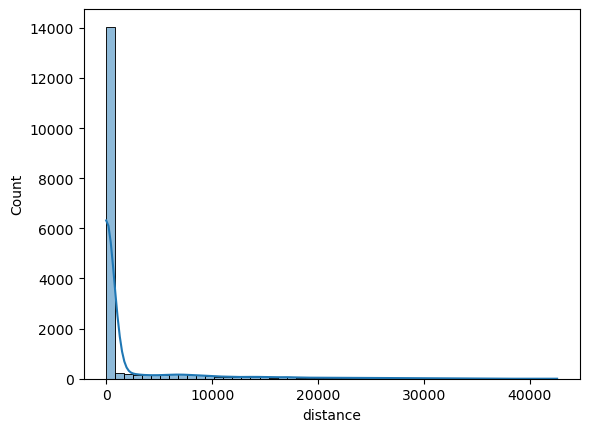

In [29]:
d = merged_lat_lon_df['distance']
sns.histplot(d,kde=True,bins=50)
plt.show()

In [ ]:
ecdf